<a href="https://colab.research.google.com/github/arthur-cen/smartTrashBin/blob/master/smart_sort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Preparation
Mounting google drive and set working directory

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
!pip install -q matplotlib-venn
%matplotlib inline

In [0]:
os.listdir('/gdrive/My Drive/Colab Notebooks/SmartSort')
%cd /gdrive/My Drive/Colab Notebooks/SmartSort
!pwd

/gdrive/My Drive/Colab Notebooks/SmartSort
/gdrive/My Drive/Colab Notebooks/SmartSort


## Data Exploration
Need to check out dataset to find out how many categories we have and if we need to preprocess the data.

### 1. Locate the Data

In [0]:
src = 'waste_resized'
waste_types = os.listdir(src)
print(waste_types)

['Tissue Paper', 'Plastic Utensil', 'Chopsticks', 'Plastic Cover', 'Sauce Packets', 'Plastic Lid', 'Chopstick Covers', 'Paper Bowl', 'Plastic Cup', 'Food', 'Straw', 'Brown box', 'Foil', 'Paper Bowl Square', 'Paper Bowl Small', 'Sauce Cup']


In [0]:
# print out how much data we have for each category
for waste_type in waste_types:
  num_img = len(os.listdir(os.path.join(src, waste_type)))
  print('---{}: {}'.format(waste_type, num_img))

---Tissue Paper: 66
---Plastic Utensil: 37
---Chopsticks: 40
---Plastic Cover: 39
---Sauce Packets: 12
---Plastic Lid: 47
---Chopstick Covers: 35
---Paper Bowl: 53
---Plastic Cup: 61
---Food: 22
---Straw: 3
---Brown box: 20
---Foil: 4
---Paper Bowl Square: 42
---Paper Bowl Small: 3
---Sauce Cup: 59


Looks like we have a pretty small dataset

In [0]:
# check the dimension of the images to see if all images have the same size
from PIL import Image

unique_sizes_set = set()
for waste_type in waste_types:
  waste_dir = os.path.join(src, waste_type)
  wastes = os.listdir(waste_dir)
  for img in wastes:
    imgFile = Image.open(os.path.join(waste_dir, img))
    width = imgFile.size[0]
    height = imgFile.size[1]
    unique_sizes_set.add((width, height))
print(unique_sizes_set)
  

{(682, 512), (384, 512), (512, 512)}


### 2. Move off-sized data and rename the images

In [0]:
# move the images that are off size to another folder
%mkdir offsize

mkdir: cannot create directory ‘offsize’: File exists


In [0]:
import shutil
for waste_type in waste_types:
  waste_dir = os.path.join(src, waste_type)
  wastes = os.listdir(waste_dir)
  for img in wastes:
    imgFile = Image.open(os.path.join(waste_dir, img))
    width = imgFile.size[0]
    height = imgFile.size[1]
    print(width, height)
    if width != 512 or height != 512:
      from_dir = os.path.join(waste_dir, img)
      to_dir = os.path.join(src, img)
      shutil.move(from_dir, to_dir)

In [0]:
## Rename the image files files
for waste_type in waste_types:
  print('renaming folder {}'.format(waste_type))
  waste_dir = os.path.join(src, waste_type)
  wastes = os.listdir(waste_dir)
  i = 1
  for filename in wastes:
    newname = '_'.join( waste_type.lower().split(' ') ) + '_' + str(i) + '.jpg'
    shutil.move(os.path.join(waste_dir, filename), os.path.join(waste_dir, newname))
    i += 1

### 3. Image data augmentation
Read later and work on it

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/ 

## Start Training

### 1. Organize images into different folders

In [0]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices  
def split_indicies(folder, seed1, seed2):
  n = len(os.listdir(folder))
  full_set = list(range(1, n+1))

  ## train indices
  random.seed(seed1)
  train = random.sample(list(range(1, n+1)), int(.5*n))

  ## temp 
  remain = list(set(full_set) - set(train))


  ## separate remaining into validation and test
  random.seed(seed2)
  valid = random.sample(remain, int(.5 *  len(remain)))
  test = list(set(remain) - set(valid))

  return(train, valid, test)
## gets file names for a particular type of trash, given indicies
  ## input: wast category and indicies
  ## output : file names
  
def get_names(waste_type, indicies):
  file_names = [('_'.join( waste_type.lower().split(' ') ) + '_' + str(i) + '.jpg') for i in indicies]
  return(file_names)
## move group of source file to another folder
  ## input a list of source files and destination folder
  ## no out put
def copy_files(source_files, destination_folder):
  for file in source_files:
    shutil.copy2(file, destination_folder)    

In [0]:
## create folders
subsets = ['train', 'valid']
for subset in subsets:
   for waste_type in waste_types:
      folder = os.path.join('main', subset, waste_type)
      if not os.path.exists(folder):
        os.makedirs(folder)
test_dir = os.path.join('main', 'test')
if not os.path.exists(test_dir):
    os.makedirs(test_dir)


In [0]:
os.listdir(os.path.join('main'))

['smart_sort.ipynb', 'image_resize.ipynb', 'train', 'valid', 'test']

In [0]:
##move files into folders
for waste_type in waste_types:
  source_folder = os.path.join(src, waste_type)
  train_ind, valid_ind, test_ind = split_indicies(source_folder, 1, 1)

  train_names = get_names(waste_type, train_ind)
  train_source_files = [os.path.join(source_folder, name) for name in train_names]
  train_dest = os.path.join('main', 'train', waste_type)
  copy_files(train_source_files, train_dest)
  
  valid_names = get_names(waste_type, valid_ind)
  valid_source_files = [os.path.join(source_folder, name) for name in valid_names]
  valid_dest = os.path.join('main', 'valid', waste_type)
  copy_files(valid_source_files, valid_dest)

  test_names = get_names(waste_type, test_ind)
  test_source_files = [os.path.join(source_folder, name) for name in test_names]
  test_dest = os.path.join('main', 'test')
  copy_files(test_source_files, test_dest)

In [0]:
for subset in ['train', 'valid']:
  print('get folder {}'.format(subset))
  for waste_type in waste_types:
    source_folder = os.path.join('main', subset, waste_type)
    print(os.listdir(source_folder))

get folder train
['tissue_paper_18.jpg', 'tissue_paper_9.jpg', 'tissue_paper_33.jpg', 'tissue_paper_8.jpg', 'tissue_paper_32.jpg', 'tissue_paper_49.jpg', 'tissue_paper_29.jpg', 'tissue_paper_31.jpg', 'tissue_paper_42.jpg', 'tissue_paper_25.jpg', 'tissue_paper_51.jpg', 'tissue_paper_14.jpg', 'tissue_paper_7.jpg', 'tissue_paper_62.jpg', 'tissue_paper_2.jpg', 'tissue_paper_57.jpg', 'tissue_paper_28.jpg', 'tissue_paper_39.jpg', 'tissue_paper_1.jpg', 'tissue_paper_45.jpg', 'tissue_paper_60.jpg', 'tissue_paper_66.jpg', 'tissue_paper_15.jpg', 'tissue_paper_38.jpg', 'tissue_paper_54.jpg', 'tissue_paper_21.jpg', 'tissue_paper_52.jpg', 'tissue_paper_40.jpg', 'tissue_paper_61.jpg', 'tissue_paper_35.jpg', 'tissue_paper_48.jpg', 'tissue_paper_56.jpg', 'tissue_paper_55.jpg']
['plastic_utensil_9.jpg', 'plastic_utensil_5.jpg', 'plastic_utensil_17.jpg', 'plastic_utensil_8.jpg', 'plastic_utensil_32.jpg', 'plastic_utensil_29.jpg', 'plastic_utensil_16.jpg', 'plastic_utensil_21.jpg', 'plastic_utensil_13.jp

In [0]:
os.listdir(os.path.join('main', 'test'))

['brown_box_12.jpg',
 'paper_bowl_square_21.jpg',
 'brown_box_16.jpg',
 'paper_bowl_square_24.jpg',
 'brown_box_17.jpg',
 'brown_box_18.jpg',
 'brown_box_20.jpg',
 'foil_4.jpg',
 'paper_bowl_square_2.jpg',
 'paper_bowl_square_3.jpg',
 'paper_bowl_square_34.jpg',
 'paper_bowl_square_38.jpg',
 'paper_bowl_square_39.jpg',
 'paper_bowl_square_11.jpg',
 'paper_bowl_square_41.jpg',
 'paper_bowl_square_12.jpg',
 'paper_bowl_square_42.jpg',
 'paper_bowl_small_3.jpg',
 'straw_3.jpg',
 'plastic_cup_3.jpg',
 'plastic_cup_4.jpg',
 'plastic_cup_40.jpg',
 'plastic_cup_35.jpg',
 'plastic_cup_43.jpg',
 'plastic_cup_36.jpg',
 'plastic_cup_26.jpg',
 'plastic_cup_12.jpg',
 'plastic_cup_59.jpg',
 'plastic_cup_16.jpg',
 'plastic_cup_60.jpg',
 'plastic_cup_20.jpg',
 'plastic_cup_61.jpg',
 'plastic_cup_22.jpg',
 'plastic_cup_23.jpg',
 'plastic_cup_56.jpg',
 'food_10.jpg',
 'food_13.jpg',
 'tissue_paper_43.jpg',
 'tissue_paper_13.jpg',
 'tissue_paper_17.jpg',
 'tissue_paper_50.jpg',
 'tissue_paper_64.jpg',
 '

In [0]:
path = Path(os.path.join(os.getcwd(), 'main'))
path

PosixPath('/gdrive/My Drive/Colab Notebooks/SmartSort/main')

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True)
data = ImageDataBunch.from_folder(path, test="test", ds_tfms=tfms, bs=8)

In [0]:
data

ImageDataBunch;

Train: LabelList (267 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Tissue Paper,Tissue Paper,Tissue Paper,Tissue Paper,Tissue Paper
Path: /gdrive/My Drive/Colab Notebooks/SmartSort/main;

Valid: LabelList (135 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Tissue Paper,Tissue Paper,Tissue Paper,Tissue Paper,Tissue Paper
Path: /gdrive/My Drive/Colab Notebooks/SmartSort/main;

Test: LabelList (141 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /gdrive/My Drive/Colab Notebooks/SmartSort/main

In [0]:
print(data.classes)


['Brown box', 'Chopstick Covers', 'Chopsticks', 'Foil', 'Food', 'Paper Bowl', 'Paper Bowl Small', 'Paper Bowl Square', 'Plastic Cover', 'Plastic Cup', 'Plastic Lid', 'Plastic Utensil', 'Sauce Cup', 'Sauce Packets', 'Straw', 'Tissue Paper']


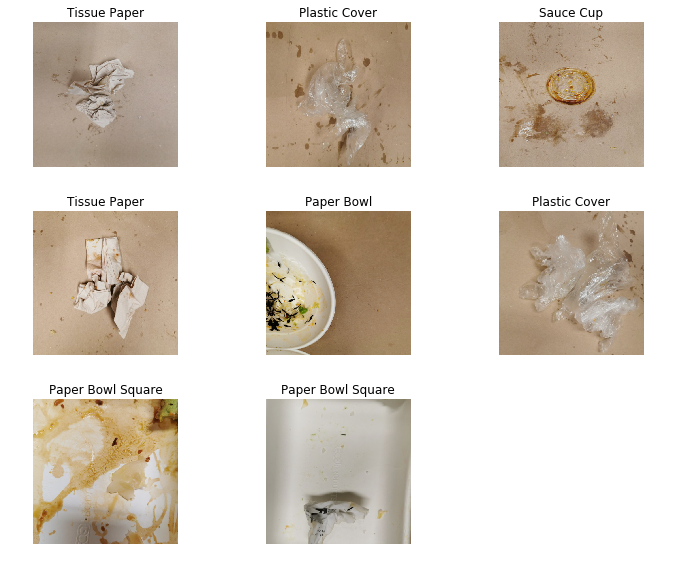

In [0]:
data.show_batch(rows=4, figsize=(10, 8))

## Model Traning

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.model

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 105MB/s] 


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

#### Finding a learnig rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


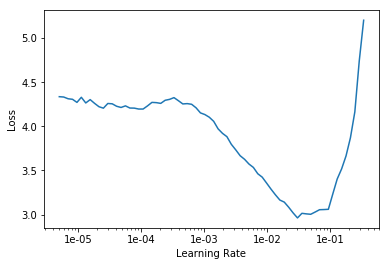

In [0]:
learn.lr_find(start_lr=1e-6, end_lr=1e1)
learn.recorder.plot()

In [0]:
learn.recorder

Recorder
learn: Learner(data=ImageDataBunch;

Train: LabelList (267 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Tissue Paper,Tissue Paper,Tissue Paper,Tissue Paper,Tissue Paper
Path: /gdrive/My Drive/Colab Notebooks/SmartSort/main;

Valid: LabelList (135 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Tissue Paper,Tissue Paper,Tissue Paper,Tissue Paper,Tissue Paper
Path: /gdrive/My Drive/Colab Notebooks/SmartSort/main;

Test: LabelList (141 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /gdrive/My Drive/Colab Notebooks/SmartSort/main, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [0]:
learn.fit_one_cycle(20, max_lr=5e-03)

epoch,train_loss,valid_loss,error_rate,time
0,3.509866,1.636707,0.518519,01:59
1,2.158628,0.384609,0.118519,00:17
2,1.326373,0.237220,0.066667,00:17
3,0.967915,0.303857,0.096296,00:16
4,0.778509,0.538287,0.118519,00:16
5,0.665252,0.554138,0.133333,00:17
6,0.674245,0.473452,0.103704,00:16
7,0.699213,0.455928,0.111111,00:17
8,0.588298,0.254827,0.059259,00:17
9,0.524494,0.395053,0.088889,00:16


In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

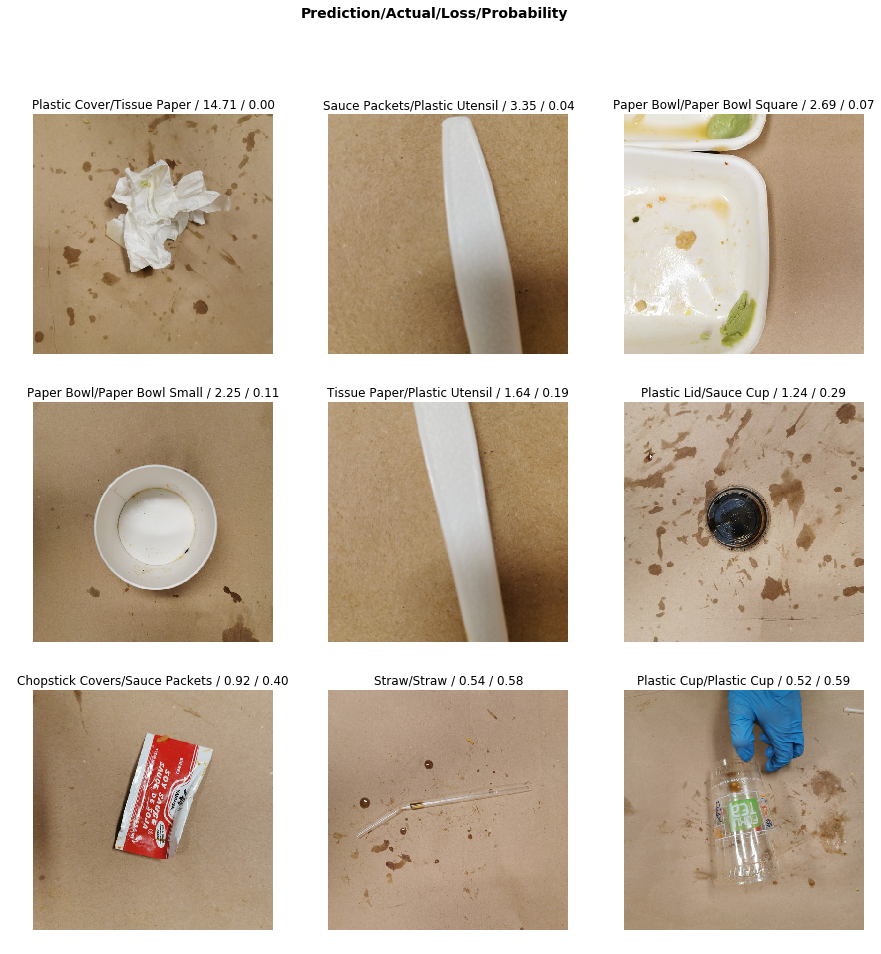

In [0]:
interp.plot_top_losses(9, figsize=(15, 15))

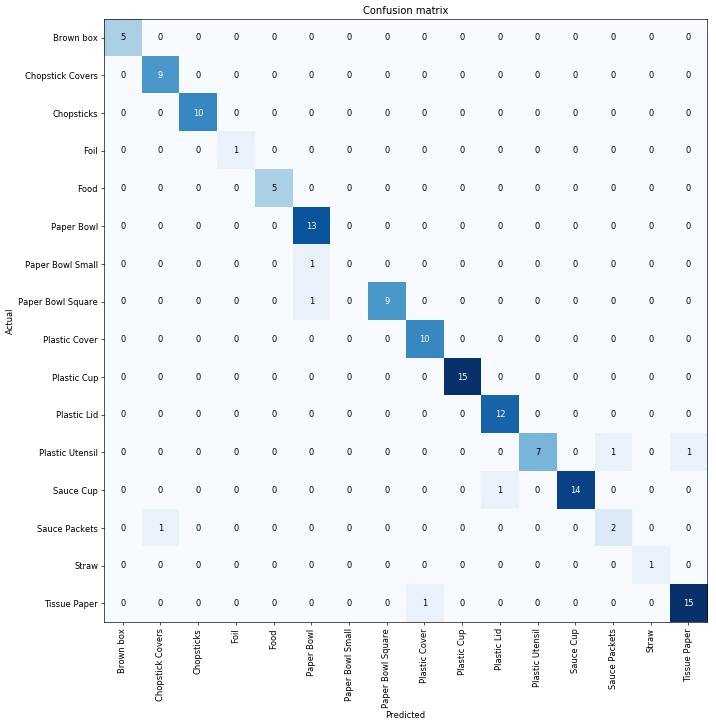

In [0]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('Plastic Utensil', 'Paper Bowl', 2)]

## 4. Make new predictions on test data

In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
print(preds[0].shape)
preds[0]

torch.Size([141, 16])


tensor([[1.0000e+00, 9.2944e-08, 3.0513e-07,  ..., 2.1125e-08, 2.1988e-06,
         9.0092e-08],
        [4.8047e-02, 4.1714e-06, 2.8580e-03,  ..., 1.8144e-02, 2.0057e-04,
         2.9085e-01],
        [1.0000e+00, 9.3183e-12, 6.7556e-10,  ..., 2.0504e-11, 1.8060e-08,
         2.8343e-07],
        ...,
        [3.3779e-06, 2.4030e-06, 4.0241e-07,  ..., 2.8049e-07, 2.7132e-06,
         2.5646e-06],
        [3.0131e-06, 5.8849e-07, 5.0847e-07,  ..., 5.4389e-07, 1.0986e-05,
         3.6049e-08],
        [9.5226e-07, 2.7246e-06, 1.8538e-07,  ..., 4.4024e-07, 1.2666e-06,
         2.3195e-08]])

In [0]:
data.classes

['Brown box',
 'Chopstick Covers',
 'Chopsticks',
 'Foil',
 'Food',
 'Paper Bowl',
 'Paper Bowl Small',
 'Paper Bowl Square',
 'Plastic Cover',
 'Plastic Cup',
 'Plastic Lid',
 'Plastic Utensil',
 'Sauce Cup',
 'Sauce Packets',
 'Straw',
 'Tissue Paper']

In [0]:
max_idxs = np.asarray(np.argmax(preds[0], axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
  name = '_'.join(data.classes[max_idx].lower().split(' '))
  yhat.append(name)

In [0]:
print(yhat)
for x in yhat:
  if x == 'straw':
    print(1)

['brown_box', 'tissue_paper', 'brown_box', 'paper_bowl_square', 'brown_box', 'brown_box', 'brown_box', 'foil', 'paper_bowl_square', 'paper_bowl_square', 'paper_bowl_square', 'paper_bowl_square', 'paper_bowl_square', 'paper_bowl_square', 'paper_bowl_square', 'paper_bowl_square', 'paper_bowl_square', 'plastic_cup', 'plastic_lid', 'plastic_cup', 'plastic_cup', 'plastic_cup', 'plastic_lid', 'plastic_cup', 'plastic_cup', 'plastic_cup', 'plastic_cup', 'plastic_cup', 'plastic_cup', 'plastic_cup', 'plastic_cup', 'plastic_cup', 'plastic_cup', 'plastic_cup', 'plastic_cup', 'food', 'food', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'tissue_paper', 'plastic_utensil', 'plastic_utensil', 'plastic_utensil', 'plastic_utensil', 'plastic_utensil', 'plastic_utensil', 'plastic_utensil', 'tissue_p

In [0]:
y = [] 
for label_path in data.test_ds.items:
  fname = str(label_path).split('/')[-1]
  fname = fname.split('.')[0]
  fname = '_'.join(fname.split('_')[:-1])
  y.append(fname)
y[:5]

['brown_box',
 'paper_bowl_square',
 'brown_box',
 'paper_bowl_square',
 'brown_box']

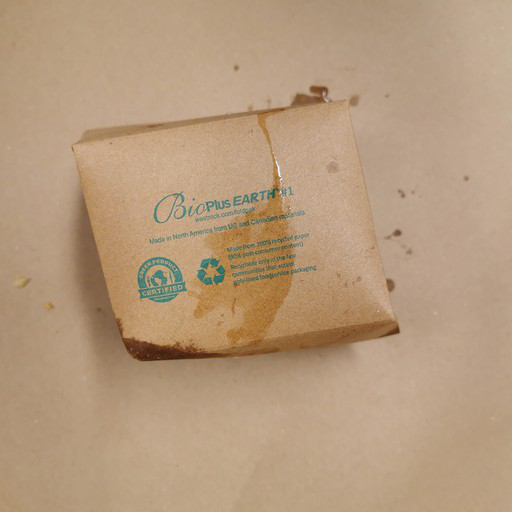

In [0]:
learn.data.test_ds[0][0]

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
labels = le.classes_
actual = le.transform(y)
predict = le.transform(yhat)
cm = confusion_matrix(actual, predict)

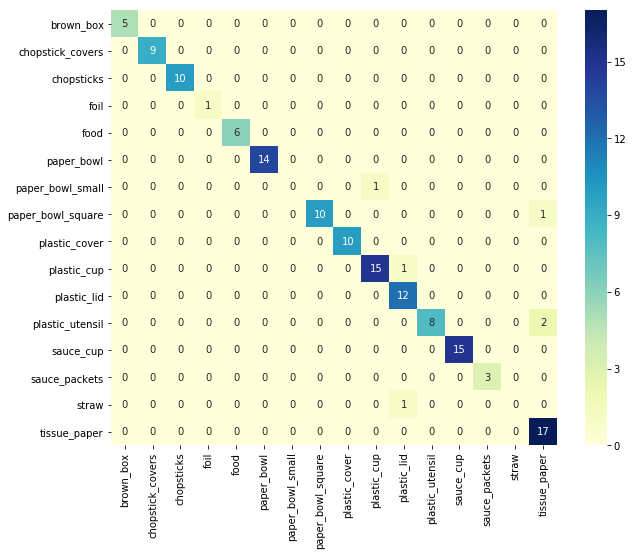

In [0]:
plt.figure(figsize=(10, 8))
df_cm = pd.DataFrame(cm, labels, labels)
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

In [0]:
correct = 0
for r in range(len(cm)):
  for c in range(len(cm)):
    if (r == c):
      correct += cm[r, c]
accuracy = correct / sum(sum(cm))
accuracy

0.9574468085106383